# 폐렴을 진단해보자🧑‍⚕️

* 의료 인공지능은 질병의 정확한 분류 또는 환자의 중증도를 확인하는 용도 등 다양한 용도로 사용되며 이 중에서 현재 가장 핫한 분야는 질병을 탐지해내는 인공지능이다. 이번 Exploration에서는 폐렴(Pneumonia)을 찾아내는 딥러닝 모델을 만들어본다.

## 1. Set-up

In [1]:
# 패키지 import
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 변수 생성
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## 2. 데이터 가져오기

In [3]:
# 데이터 가져오기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))  # 갯수 확인
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져오기
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1346-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person315_bacteria_1466.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


* 결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있습니다. 우리가 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 합니다. 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다. test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없습니다.

In [7]:
# tf.data 인스턴스를 만들어 봅시다. tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해 줍니다.
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
# Train 데이터셋, validation 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 라벨 데이터를 만들어 주는 함수
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
# train 데이터 셋과 validation 데이터 셋 생성
# num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 즐 수 있다
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):  # 하나의 데이터만 가져온다는 의미
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
#  test 데이터셋 생성
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다. tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환시켜주겠습니다.

* shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.
* repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다. 예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.
* batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다. 예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.
* prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3. 데이터 시각화
* 데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출합니다. 추출된 배치를 image와 label 데이터 셋으로 나눕니다. 이제 show_batch() 함수를 이용해서 결과 사진을 보겠습니다.

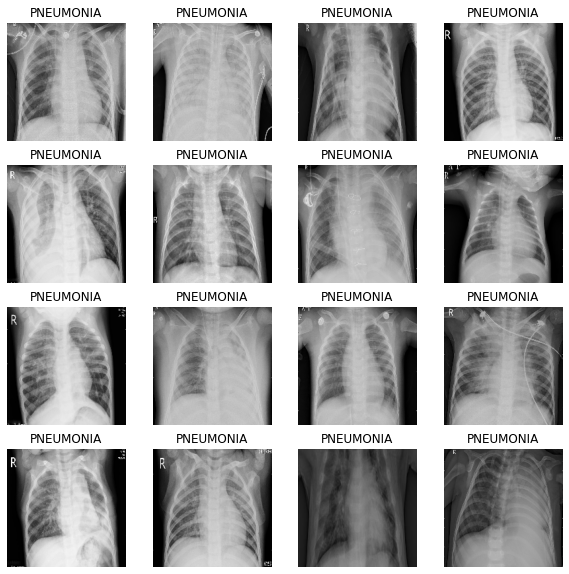

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4. CNN 모델링
* 이미지 처리에 특화된 딥러닝 모델인 CNN을 통해 모델링을 하고 결과를 만들어 보겠습니다.

In [16]:
def conv_block(filters):  # Convolution block생성
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units, dropout_rate):  # Dense Block생성
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

Batch Normalization과 Dropout을 함께 사용했을때 성능 향상이 있는가?


In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalance 처리
* 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있습니다. 이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용됩니다. Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다. Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다. https://3months.tistory.com/414

* 아래 코드에서 weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅합니다. 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됩니다.

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## 6. 모델 훈련
* 이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택합니다. 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언합니다.
* 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다. optimizer로 'adam'을 사용합니다.
* 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용합니다.

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es]
    )

Epoch 1/25
261/261 [==============================] - 78s 223ms/step - loss: 0.3703 - accuracy: 0.8350 - precision: 0.9583 - recall: 0.8137 - val_loss: 0.7124 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 48s 184ms/step - loss: 0.2379 - accuracy: 0.9071 - precision: 0.9693 - recall: 0.9038 - val_loss: 1.2754 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 48s 185ms/step - loss: 0.2188 - accuracy: 0.9188 - precision: 0.9723 - recall: 0.9167 - val_loss: 0.4365 - val_accuracy: 0.7827 - val_precision: 0.7722 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 49s 187ms/step - loss: 0.1881 - accuracy: 0.9296 - precision: 0.9809 - recall: 0.9235 - val_loss: 0.3375 - val_accuracy: 0.8173 - val_precision: 0.8010 - val_recall: 1.0000
Epoch 5/25
261/261 [==============================] - 50s 192ms/step - loss: 0.1743 - accura

## 7. 결과 확인과 시각화
* 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.

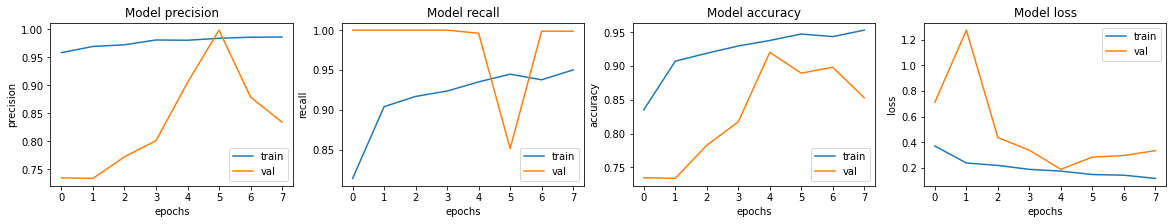

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 108ms/step - loss: 1.1830 - accuracy: 0.6587 - precision: 0.6468 - recall: 1.0000
Loss: 1.1829590797424316,
Accuracy: 0.6586538553237915,
Precision: 0.646766185760498,
Recall: 1.0


# 프로젝트 : 폐렴 진단기 성능개선

위에서 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다.
이것은 일반적으로 잘 사용되는 형태는 아닙니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료 영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다. 만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다. BatchNormalization과 Dropout을 하나만 쓰거나 둘 다 쓰지 않는 구성을 테스트합니다.

### 1. BatchNormalization만

In [25]:
def dense_block_1(units, dropout_rate):  # Dense Block생성
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization()
    ])
    
    return block

### 2. Dropout만

In [26]:
def dense_block_2(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

### 3. 둘 다 사용안함

In [27]:
def dense_block_3(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        
    ])
    
    return block

In [28]:
def build_model_1():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_1(512, 0.7),
        dense_block_1(128, 0.5),
        dense_block_1(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [29]:
def build_model_2():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_2(512, 0.7),
        dense_block_2(128, 0.5),
        dense_block_2(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [30]:
def build_model_3():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_3(512),
        dense_block_3(128),
        dense_block_3(64),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Step 5. 데이터 imbalance 처리

In [31]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## Step 6. 모델 훈련

### 1. BatchNormalization만

In [32]:
with tf.device('/GPU:0'):
    model_b = build_model_1()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_b.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [33]:
with tf.device('/GPU:0'):
    history_b = model_b.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es]
    )

Epoch 1/25
261/261 [==============================] - 57s 184ms/step - loss: 0.2588 - accuracy: 0.8858 - precision: 0.9676 - recall: 0.8757 - val_loss: 0.8617 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 48s 183ms/step - loss: 0.1909 - accuracy: 0.9279 - precision: 0.9785 - recall: 0.9234 - val_loss: 2.1956 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 48s 183ms/step - loss: 0.1415 - accuracy: 0.9435 - precision: 0.9854 - recall: 0.9378 - val_loss: 0.7520 - val_accuracy: 0.7471 - val_precision: 0.7439 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 48s 184ms/step - loss: 0.1263 - accuracy: 0.9526 - precision: 0.9863 - recall: 0.9495 - val_loss: 0.1878 - val_accuracy: 0.9308 - val_precision: 0.9149 - val_recall: 0.9987
Epoch 5/25
261/261 [==============================] - 48s 185ms/step - loss: 0.1096 - accura

### 2. Dropout만

In [34]:
with tf.device('/GPU:0'):
    model_d = build_model_2()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_d.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [35]:
with tf.device('/GPU:0'):
    history_d = model_d.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es]
    )

Epoch 1/25
261/261 [==============================] - 57s 184ms/step - loss: 0.4190 - accuracy: 0.8147 - precision: 0.9004 - recall: 0.8442 - val_loss: 0.5901 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 48s 183ms/step - loss: 0.2233 - accuracy: 0.9054 - precision: 0.9795 - recall: 0.8916 - val_loss: 3.1545 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 47s 182ms/step - loss: 0.1848 - accuracy: 0.9255 - precision: 0.9817 - recall: 0.9170 - val_loss: 0.3075 - val_accuracy: 0.8683 - val_precision: 0.8486 - val_recall: 0.9987
Epoch 4/25
261/261 [==============================] - 48s 184ms/step - loss: 0.1378 - accuracy: 0.9473 - precision: 0.9888 - recall: 0.9397 - val_loss: 0.1543 - val_accuracy: 0.9471 - val_precision: 0.9371 - val_recall: 0.9948
Epoch 5/25
261/261 [==============================] - 49s 186ms/step - loss: 0.1370 - accura

### 3. 둘다 사용안함

In [36]:
with tf.device('/GPU:0'):
    model_n = build_model_3()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_n.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [37]:
with tf.device('/GPU:0'):
    history_n = model_n.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es]
    )

Epoch 1/25
261/261 [==============================] - 56s 184ms/step - loss: 0.3062 - accuracy: 0.8592 - precision: 0.9663 - recall: 0.8401 - val_loss: 0.6563 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 48s 184ms/step - loss: 0.1489 - accuracy: 0.9368 - precision: 0.9830 - recall: 0.9311 - val_loss: 1.1017 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 47s 182ms/step - loss: 0.1180 - accuracy: 0.9516 - precision: 0.9882 - recall: 0.9462 - val_loss: 0.8219 - val_accuracy: 0.7981 - val_precision: 0.7848 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 48s 184ms/step - loss: 0.0934 - accuracy: 0.9629 - precision: 0.9881 - recall: 0.9617 - val_loss: 0.1963 - val_accuracy: 0.9413 - val_precision: 0.9903 - val_recall: 0.9295
Epoch 5/25
261/261 [==============================] - 49s 187ms/step - loss: 0.1010 - accura

## Step 7. 결과 확인과 시각화

### 1. BatchNormalization만

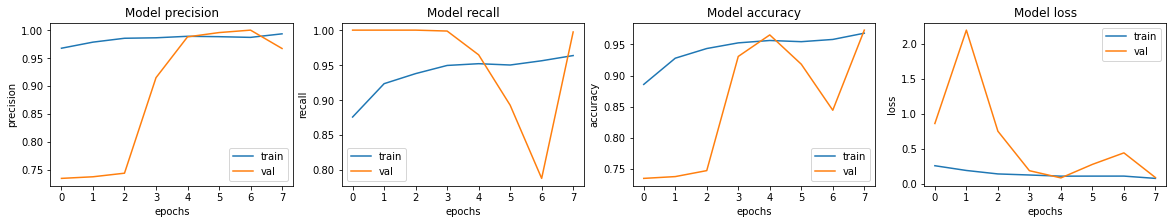

In [38]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_b.history[met])
    ax[i].plot(history_b.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [39]:
loss, accuracy, precision, recall = model_b.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 110ms/step - loss: 1.3725 - accuracy: 0.7131 - precision: 0.6854 - recall: 1.0000
Loss: 1.3724744319915771,
Accuracy: 0.7131410241127014,
Precision: 0.6854130029678345,
Recall: 1.0


### 2. Dropout만

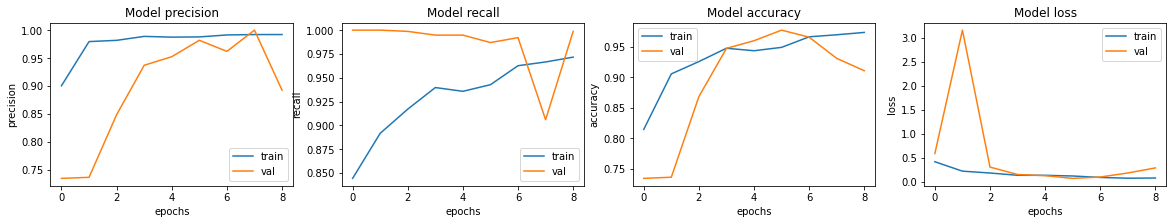

In [40]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_d.history[met])
    ax[i].plot(history_d.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [41]:
loss, accuracy, precision, recall = model_d.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 100ms/step - loss: 3.3591 - accuracy: 0.6571 - precision: 0.6457 - recall: 1.0000
Loss: 3.3591089248657227,
Accuracy: 0.6570512652397156,
Precision: 0.6456953883171082,
Recall: 1.0


### 3. 둘다 사용안함

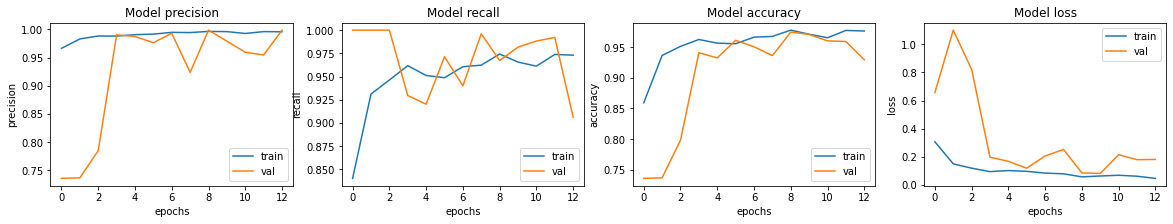

In [42]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_n.history[met])
    ax[i].plot(history_n.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [43]:
loss, accuracy, precision, recall = model_n.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 107ms/step - loss: 0.7103 - accuracy: 0.8349 - precision: 0.8140 - recall: 0.9538
Loss: 0.7103169560432434,
Accuracy: 0.8349359035491943,
Precision: 0.8140043616294861,
Recall: 0.9538461565971375


### 4. Convolution block에서 합성곱 층을 한번으로 줄여서 앞에서 accuracy가 가장 높게 나온 둘 다 사용하지 않는 구성을 다시 테스트한다.

In [49]:
def conv_block(filters):  # Convolution block생성
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [50]:
with tf.device('/GPU:0'):
    model_n = build_model_3()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_n.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [51]:
with tf.device('/GPU:0'):
    history_n = model_n.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[es]
    )

Epoch 1/25
261/261 [==============================] - 55s 179ms/step - loss: 0.2845 - accuracy: 0.9171 - precision: 0.9755 - recall: 0.9115 - val_loss: 2.4439 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 45s 175ms/step - loss: 0.1282 - accuracy: 0.9526 - precision: 0.9869 - recall: 0.9488 - val_loss: 3.4995 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 46s 176ms/step - loss: 0.0989 - accuracy: 0.9660 - precision: 0.9907 - recall: 0.9633 - val_loss: 0.1496 - val_accuracy: 0.9596 - val_precision: 0.9932 - val_recall: 0.9517
Epoch 4/25
261/261 [==============================] - 46s 178ms/step - loss: 0.0914 - accuracy: 0.9655 - precision: 0.9910 - recall: 0.9623 - val_loss: 0.2953 - val_accuracy: 0.8942 - val_precision: 0.9970 - val_recall: 0.8590
Epoch 5/25
261/261 [==============================] - 47s 181ms/step - loss: 0.0666 - accura

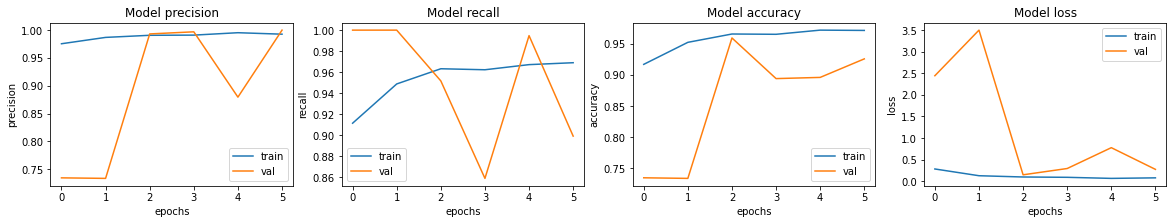

In [52]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_n.history[met])
    ax[i].plot(history_n.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [53]:
loss, accuracy, precision, recall = model_n.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 96ms/step - loss: 0.4496 - accuracy: 0.8750 - precision: 0.8824 - recall: 0.9231
Loss: 0.44961366057395935,
Accuracy: 0.875,
Precision: 0.8823529481887817,
Recall: 0.9230769276618958


# 회고

이번 Exploration는 정말 힘들고 오래걸렸다. 커널이 도중에 죽고, 여러 오류들과 싸우고, 많은 시도를 하며 모델이 학습되길 기다리며 스스로와 싸운끝에 루브릭 평가기준을 겨우 넘겼다😭

|모델|accuracy|recall|
|:--------|---|---|
|기존모델|0.6587|1.0000|
|BatchNormalization만|0.7131|1.0000|
|Dropout만|0.6571|1.0000|
|둘 다 사용안함|0.8349|0.9538|
|conv block 채널 1개 + 둘 다 사용안함|<span style="color:red">0.8750</span>|0.9231|

* 결과를 살펴보면 의외로 BatchNormalization과 Dropout을 둘 다 적용하지 않고, conv block 합성곱 층을 한번으로 줄인 모델이 가장 높은 정확도를 기록했다. 하지만 recall값이 낮게 나온 것이 마음에 걸린다. 양성환자를 음성으로 오진하는 경우가 많으면 안되기 때문이다.
* 의료 인공지능의 도입이 더딘 이유를 실습을 하며 느꼈다. 양질의 데이터가 아주 많이 준비되어 있고 최적의 모델로 학습을 해야 하는데 데이터도 부족하고, 변수도 많을 수 있어서 쉽지 않은 것 같다.